In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
	dtype = torch.cuda.FloatTensor
else:
	dtype = torch.FloatTensor


text_file_19982012 = '19982012.pkl'
text_file_20142018 = '20142018.pkl'
text_file_20122014 = '20122014.pkl'

#Defines the amount of hours later we want to forecast the Dst
forecasthour = 5

#maximum total amount of epochs
#do not take this tooo low because when error on CV will not increase (when locl minimum, when learning rate too small)
num_epochs = 500

input_size = 5
output_size = 1

#hyperparameters from grid
num_layers = 1
hidden_layer_size = 32
learning_rate = 0.0001
lookbackhour = 30
batch_size = 128
dropout = 0

In [2]:


# load in the scaler data 1998-2012

datapanda = pd.read_pickle(text_file_19982012)

#Quentifify total number of parameters - timestamps
NrParam = datapanda.values[0].shape[0] - 3
#get all the input parameters including Dst (without timestamps)
inputdata = datapanda.loc[:,3:(2+NrParam)].values
#get the Dst output
outputdata = datapanda.loc[:,6].values
outputdata = outputdata.reshape(-1, 1)

#use the preprocessing tool of sklearn to rescale data between -1 and 1
inputscaler = preprocessing.StandardScaler()
inputscaler.fit(inputdata)
traininginput = inputdata
trainingoutput = outputdata
#save scaler to later inverse the scaled result
scaler = preprocessing.StandardScaler()
scaler.fit(outputdata)

# load in the cv data 2012-2014

datapanda = pd.read_pickle(text_file_20122014)

#Quentifify total number of parameters - timestamps
NrParam = datapanda.values[0].shape[0] - 3
#get all the input parameters including Dst (without timestamps)
CVinput = datapanda.loc[:,3:(2+NrParam)].values
#get the Dst output
CVoutput = datapanda.loc[:,6].values
CVoutput = CVoutput.reshape(-1, 1)

# load in the test data 2014-2019

datapanda = pd.read_pickle(text_file_20142018)

#Quentifify total number of parameters - timestamps
NrParam = datapanda.values[0].shape[0] - 3
#get all the input parameters including Dst (without timestamps)
testinput = datapanda.loc[:,3:(2+NrParam)].values
#get the Dst output
testoutput = datapanda.loc[:,6].values
testoutput = testoutput.reshape(-1, 1)

realtestoutput = testoutput
realtestinput = testinput


traininginput = inputscaler.transform(traininginput)
CVinput = inputscaler.transform(CVinput)
testinput = inputscaler.transform(testinput)
trainingoutput = scaler.transform(trainingoutput)
CVoutput = scaler.transform(CVoutput)
testoutput = scaler.transform(testoutput)


def create_dataset(datasetinput, datasetoutput, look_back, forecast):
    dataX, dataY = [],[]
    for i in range(len(datasetinput) - int(look_back) - int(forecast) - 1):
        x = datasetinput[i:(i+int(look_back))]
        dataX.append(x)
        y = datasetoutput[(i+int(forecast)):(i+int(look_back)+int(forecast))]
        dataY.append(y)
    return np.array(dataX), np.array(dataY), len(dataY)

def prepare_data(inputdata, outputdata, lookback, forecast, batchsize):
    lookback = int(lookback)
    forecast = int(forecast)
    batchsize = int(batchsize)

    numberofdata = len(inputdata)
    number_of_batches = (numberofdata // batchsize)

    #create a list where we will put all the batches in
    Xlist = []
    Ylist = []

    dataX, dataY, numberdummy = create_dataset(inputdata, outputdata, lookback, forecast)
    
    #random shuffle the samples 
    indices = np.arange(dataX.shape[0])
    np.random.shuffle(indices)
    dataX = dataX[indices]
    dataY = dataY[indices]

    for b in range(0,number_of_batches-1):
        Xbatch2 = dataX[(b*batchsize):((b+1)*batchsize)]
        Ybatch2 = dataY[(b*batchsize):((b+1)*batchsize)]
        Xtensor2 = torch.Tensor(Xbatch2).type(dtype)
        #transpose because we want shape (seq length, batchsize, number of features)
        Xtensor2 = Xtensor2.transpose(1,0)
        Ytensor2 = torch.Tensor(Ybatch2).type(dtype)
        Ytensor2 = Ytensor2.transpose(1,0)
        #add tensor batches to lists of all batches
        Xlist.append(Xtensor2)
        Ylist.append(Ytensor2)   

    return Xlist, Ylist


/home/jaripeeperkorn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jaripeeperkorn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jaripeeperkorn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jaripeeperkorn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
# Here we define our model as a class
class lstm(nn.Module):
	def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
		super(lstm, self).__init__()
		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.num_layers = num_layers
		self.dropout = dropout

		# Define the LSTM layer(s)
		self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout = self.dropout)

		# Define the output layer
		self.linear = nn.Linear(self.hidden_dim, output_dim)

	def forward(self, input):
		batch_size = input.size(1)
		hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).type(dtype), torch.zeros(self.num_layers, batch_size, self.hidden_dim).type(dtype)
		# Forward pass through LSTM layer
		# shape of lstm_out: [input sequence length, batch_size, hidden_dim (features)]
		# shape of self.hidden: (a, b), where a and b both have shape (num_layers, batch_size, hidden_dim).
		lstm_out, hidden = self.lstm(input.view(len(input), batch_size, -1))
		y_pred = self.linear(lstm_out)
		return y_pred

'''
def MSE_last(pred, target):
	error = 0
	for i in range(0, pred.shape[1]):
		errorpart = (target[-1, i, 0] - pred[-1, i, 0])**2
		error = error + errorpart
	error = error/pred.shape[1]
'''
#We use MSE loss
loss_fn = nn.MSELoss()


#prepare the data with the function above
trainX, trainY = prepare_data(traininginput, trainingoutput, lookbackhour, forecasthour, batch_size)
cvX, cvY = prepare_data(CVinput, CVoutput, lookbackhour, forecasthour, batch_size)
testX, testY = prepare_data(testinput, testoutput, lookbackhour, forecasthour, batch_size)

#create unscaled versions to use to test later
textXunsc, textYunsc = prepare_data(realtestinput, realtestoutput, lookbackhour, forecasthour, 1)

#define new model
model = lstm(input_size, hidden_layer_size, output_dim=output_size, num_layers=num_layers, dropout=dropout)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
if torch.cuda.is_available():
	model = model.cuda()
histtrain = np.zeros(num_epochs)
histcv = np.zeros(num_epochs)
histtest = np.zeros(num_epochs)


In [4]:
#model.train()
for e in range(num_epochs):
	hist3 = np.zeros(len(cvX))
	for l in range(0, len(cvX)):
		predcv = model(cvX[l])
		targ = cvY[l]
		losscv = loss_fn(predcv[-1], targ[-1])
		hist3[l] = losscv.item()
	histcv[e] = np.average(hist3)

	hist2 = np.zeros(len(testX))
	for w in range(0, len(testX)):
		predtest = model(testX[w])
		targ = testY[w]
		losstest = loss_fn(predtest[-1], targ[-1])
		hist2[w] = losstest.item()
	histtest[e] = np.average(hist2)


	hist = np.zeros(len(trainX))
	for t in range(0, len(trainX)):
		#Do I have to uncomment? zero grad?   
		#model.zero_grad()
		prediction = model(trainX[t])
		loss = loss_fn(prediction, trainY[t])
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		target = trainY[t]
		losstrain = loss_fn(prediction[-1], target[-1])
		hist[t] = losstrain.item()
		#print("Epoch: ", e, ", Batch: ", t, " Loss: ", loss.item())
	histtrain[e] = np.average(hist)
	print("Epoch: ", e, " Loss: ", np.average(hist))
	#we need to be able to check if the network is overfitting afterwards so we want test loss history as well
	#if we are in the first 3 loops skip the next step
	if e<2:
		continue
	#stop when average CV loss has been increasing for two epochs
	if histtest[e]>histtest[e-1] and histtest[e-1]>histtest[e-2]:
		break
histtrain = histtrain[0:e]
histcv = histcv[0:e]
histtest = histtest[0:e]

Epoch:  0  Loss:  0.39511789849378726
Epoch:  1  Loss:  0.24486477879408944
Epoch:  2  Loss:  0.21969125805323914
Epoch:  3  Loss:  0.20886114322098562
Epoch:  4  Loss:  0.2023621181969342
Epoch:  5  Loss:  0.19789484473561675
Epoch:  6  Loss:  0.19463092677799176
Epoch:  7  Loss:  0.19209384814013727
Epoch:  8  Loss:  0.19000638962146132
Epoch:  9  Loss:  0.18821325141534725
Epoch:  10  Loss:  0.1866223547859645
Epoch:  11  Loss:  0.18518319731438618
Epoch:  12  Loss:  0.18386856617041655
Epoch:  13  Loss:  0.18265432273965648
Epoch:  14  Loss:  0.18151803946691195
Epoch:  15  Loss:  0.1804451791525323
Epoch:  16  Loss:  0.17942903994478734
Epoch:  17  Loss:  0.17846578341896835
Epoch:  18  Loss:  0.17755063102875157
Epoch:  19  Loss:  0.176677815078109
Epoch:  20  Loss:  0.1758415147634921
Epoch:  21  Loss:  0.175037058053276


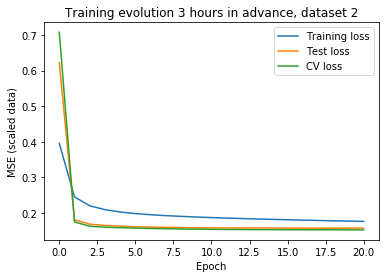

In [5]:
plt.plot(histtrain, label="Training loss")
plt.plot(histtest, label="Test loss")
plt.plot(histcv, label="CV loss")
plt.title('Training evolution 5 hours in advance, dataset 2')
plt.xlabel('Epoch')
plt.ylabel('MSE (scaled data)')
plt.legend()
plt.savefig('training', format='pdf')
plt.show()

In [6]:
def CC(predarr, realarr):
    predave = np.mean(predarr)
    realave = np.mean(realarr)
    top = 0
    bottom1 = 0
    bottom2 = 0
    for i in (0, predarr.size-1):
        top = top + ((predarr[i] - predave)*(realarr[i]-realave))
        bottom1 = bottom1 + (predarr[i] - predave)**2
        bottom2 = bottom2 + (realarr[i] - realave)**2
    bottom = np.sqrt(bottom1) * np.sqrt(bottom2)
    R = np.divide(top,bottom)
    return(R)


In [7]:
np.savetxt('Learning_History_train.txt', histtrain, fmt='%d')
np.savetxt('Learning_History_cv.txt', histcv, fmt='%d')
np.savetxt('Learning_History_test.txt', histtest, fmt='%d')
# Saves only the models parameters
torch.save(model.state_dict(), 'model_parameters.ckpt')
#saves entire model
torch.save(model, 'model.pth')

/home/jaripeeperkorn/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
def prepare_data2(inputdata, outputdata, lookback, forecast, batchsize):
	lookback = int(lookback)
	forecast = int(forecast)
	batchsize = int(batchsize)

	numberofdata = len(inputdata)
	number_of_batches = (numberofdata // batchsize) - lookback - forecast

	#create a list where we will put all the batches in
	Xlist = []
	Ylist = []

	dataX, dataY, numberdummy = create_dataset(inputdata, outputdata, lookback, forecast)

	for b in range(0,number_of_batches-1):
		Xbatch2 = dataX[(b*batchsize):((b+1)*batchsize)]
		Ybatch2 = dataY[(b*batchsize):((b+1)*batchsize)]
		Xtensor2 = torch.Tensor(Xbatch2).type(dtype)
		#transpose because we want shape (seq length, batchsize, number of features)
		Xtensor2 = Xtensor2.transpose(1,0)
		Ytensor2 = torch.Tensor(Ybatch2).type(dtype)
		Ytensor2 = Ytensor2.transpose(1,0)
		#add tensor batches to lists of all batches
		Xlist.append(Xtensor2)
		Ylist.append(Ytensor2)

	return Xlist, Ylist


In [9]:
testX, testY = prepare_data2(testinput, testoutput, lookbackhour, forecasthour, 1)

#create unscaled versions to use to test later
testXunsc, testYunsc = prepare_data2(realtestinput, realtestoutput, lookbackhour, forecasthour, 1)

print(len(testX))
print(len(testXunsc))

36444
36444


In [10]:
#ADD .cpu() back!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


pos = lookbackhour - 1


predictiontest = np.zeros(len(testX))
ytestplot = np.zeros(len(testX))

for i in range(0, len(testX)):
    #model.hidden = model.init_hidden()
    predic = model(testX[i])
    #only intereseted in last point as this is the actual predicition
    pred = predic[-1]
    pred= pred.detach().numpy()
    pred = scaler.inverse_transform(pred)
    targetdum = testYunsc[i]
    target = targetdum[-1]
    target = target.detach().numpy()
    predictiontest[i] = np.squeeze(pred)
    ytestplot[i] = np.squeeze(target)
    print(i)

print(predictiontest)   
print(ytestplot)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098


3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782


5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458


6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101


8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742


10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
1035

11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
1172

12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
1309

14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
1446

15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
1585

17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
1724

18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
1863

19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
2002

21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
2140

22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
22730
22731
22732
22733
22734
22735
22736
22737
22738
22739
22740
22741
22742
22743
22744
22745
22746
22747
22748
22749
22750
22751
22752
22753
22754
22755
22756
22757
22758
22759
22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772
22773
22774
22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785
22786
22787
22788
22789
22790
2279

24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
24165
24166
24167
24168
24169
24170
24171
24172
24173
24174
24175
24176
24177
24178
24179
24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
2419

25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
25492
25493
25494
25495
25496
25497
25498
25499
25500
25501
25502
25503
25504
25505
25506
25507
25508
25509
25510
25511
25512
25513
25514
25515
25516
25517
25518
25519
25520
25521
25522
25523
25524
25525
25526
25527
25528
25529
25530
25531
25532
25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
2556

26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809
26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824
26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883
26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894
26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905
26906
26907
26908
26909
26910
26911
26912
26913
26914
26915
26916
26917
26918
26919
26920
26921
26922
26923
26924
26925
26926
26927
26928
26929
26930
26931
26932
26933
26934
26935
26936
26937
26938
26939
2694

28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
28262
28263
28264
28265
28266
28267
28268
28269
28270
28271
28272
28273
28274
28275
28276
28277
28278
28279
28280
28281
28282
28283
28284
28285
28286
28287
28288
28289
28290
28291
28292
28293
28294
28295
28296
28297
28298
28299
28300
28301
28302
28303
28304
28305
28306
28307
28308
28309
28310
28311
28312
28313
2831

29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
2971

30930
30931
30932
30933
30934
30935
30936
30937
30938
30939
30940
30941
30942
30943
30944
30945
30946
30947
30948
30949
30950
30951
30952
30953
30954
30955
30956
30957
30958
30959
30960
30961
30962
30963
30964
30965
30966
30967
30968
30969
30970
30971
30972
30973
30974
30975
30976
30977
30978
30979
30980
30981
30982
30983
30984
30985
30986
30987
30988
30989
30990
30991
30992
30993
30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
3109

32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
32340
32341
32342
32343
32344
32345
32346
32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440
32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
3248

33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
33855
33856
3385

35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
35172
35173
35174
35175
35176
35177
35178
35179
35180
35181
35182
35183
35184
35185
35186
35187
35188
35189
35190
35191
35192
35193
35194
35195
35196
35197
35198
35199
35200
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226
35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
35247
35248
35249
35250
35251
35252
35253
3525

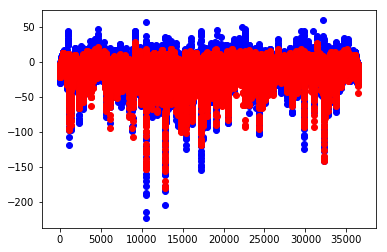

In [11]:
testtimes = torch.arange(0, len(testX))
plt.scatter(testtimes, ytestplot, color='b')
plt.scatter(testtimes, predictiontest, color='r')
plt.show()
#plt.savefig(ytest

In [12]:

def persistance(inputlist, Dstloc):
    output = np.zeros(len(inputlist))
    for i in range(0, len(inputlist)):
        inputbatch = inputlist[i]
        output[i] = inputbatch[-1, 0, Dstloc]
    return(output)

perstest = persistance(testXunsc, 3)

'''
predictiontest= predictiontest[0:44473]
ytestplot = ytestplot[0:44473]
perstest = perstest[0:44473]
'''



'\npredictiontest= predictiontest[0:44473]\nytestplot = ytestplot[0:44473]\nperstest = perstest[0:44473]\n'

In [13]:
print(ytestplot[-15:-1])
print(perstest[-15:-1])


[-20. -20. -18. -21. -20. -20. -18. -15. -13. -14. -15. -16. -16. -15.]
[ -6. -10. -13. -13. -18. -20. -20. -18. -21. -20. -20. -18. -15. -13.]


In [14]:
def CC2(r1, r2):
    return (np.cov(r1,r2)[0][1])/np.sqrt(np.var(r1)*np.var(r2))

In [15]:
error = 0
errorpers = 0
MAE = 0
MAEpers = 0

i = 0
for i in range(0, len(predictiontest)):
    error = error + (ytestplot[i] - predictiontest[i])**2
    errorpers = errorpers +  (ytestplot[i] - perstest[i])**2
    MAE = MAE + np.absolute(ytestplot[i] - predictiontest[i])
    MAEpers = MAEpers + np.absolute(ytestplot[i] - perstest[i])
    
MAE = MAE/len(predictiontest)
MAEpers = MAEpers/len(perstest)
    
error = np.sqrt(error / len(predictiontest))
errorpers = np.sqrt(errorpers / len(perstest))


rmse2test = np.sqrt(mse(ytestplot, predictiontest))
rmse2pers = np.sqrt(mse(ytestplot, perstest))

mae2test = mae(ytestplot, predictiontest)
mae2pers = mae(ytestplot, perstest)

Rmodel = CC2(predictiontest, ytestplot)
Rpers = CC2(perstest, ytestplot)

print("RMSE of test data ", forecasthour, " hours in advance forecast: ", error, rmse2test)
print("RMSE of persistance model on test data ", forecasthour, " hours in advance forecast: ", errorpers, rmse2pers)
print("R of test data ", forecasthour, " hours in advance forecast: ", Rmodel)
print("R of persistance model on test data ", forecasthour, " hours in advance forecast: ", Rpers)
print("MAE of test data ", forecasthour, " hours in advance forecast: ", MAE, mae2test)
print("MAE of persistance model on test data ", forecasthour, " hours in advance forecast: ", MAEpers, mae2pers)

RMSE of test data  5  hours in advance forecast:  8.51094552916518 8.510945529165069
RMSE of persistance model on test data  5  hours in advance forecast:  10.491852575939566 10.491852575939566
R of test data  5  hours in advance forecast:  0.8726114279215539
R of persistance model on test data  5  hours in advance forecast:  0.8187025687342715
MAE of test data  5  hours in advance forecast:  5.834403938715533 5.834403938715533
MAE of persistance model on test data  5  hours in advance forecast:  7.022006365931292 7.022006365931292


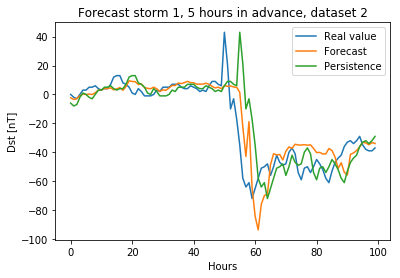

In [16]:
plt.plot(ytestplot[30930:31030], label='Real value')
plt.plot(predictiontest[30930:31030], label='Forecast')
plt.plot(perstest[30930:31030], label='Persistence')
plt.legend()
plt.title('Forecast storm 1, 5 hours in advance, dataset 2')
plt.xlabel('Hours')
plt.ylabel('Dst [nT]')
plt.savefig('storm1', format='pdf')
plt.show()

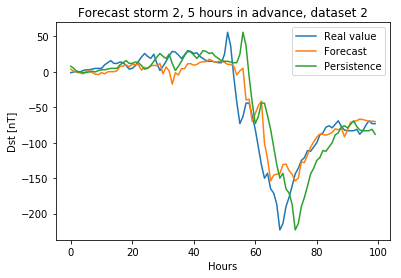

In [17]:
plt.plot(ytestplot[10480:10580], label='Real value')
plt.plot(predictiontest[10480:10580], label='Forecast')
plt.plot(perstest[10480:10580], label='Persistence')
plt.legend()
plt.title('Forecast storm 2, 5 hours in advance, dataset 2')
plt.xlabel('Hours')
plt.ylabel('Dst [nT]')
plt.savefig('storm2', format='pdf')
plt.show()

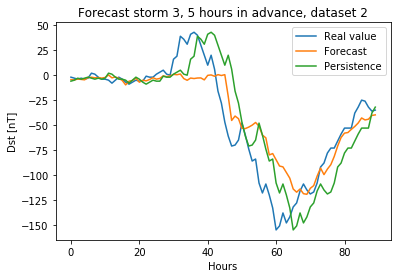

In [18]:
plt.plot(ytestplot[17160:17250], label='Real value')
plt.plot(predictiontest[17160:17250], label='Forecast')
plt.plot(perstest[17160:17250], label='Persistence')
plt.legend()
plt.title('Forecast storm 3, 5 hours in advance, dataset 2')
plt.xlabel('Hours')
plt.ylabel('Dst [nT]')
plt.savefig('storm3', format='pdf')
plt.show()

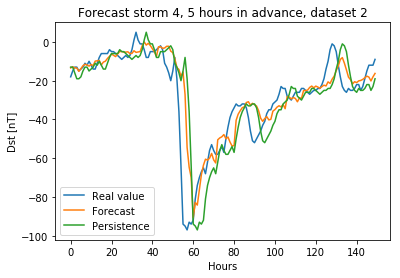

In [19]:
plt.plot(ytestplot[1300:1450], label='Real value')
plt.plot(predictiontest[1300:1450], label='Forecast')
plt.plot(perstest[1300:1450], label='Persistence')
plt.legend()
plt.title('Forecast storm 4, 5 hours in advance, dataset 2')
plt.xlabel('Hours')
plt.ylabel('Dst [nT]')
plt.savefig('storm4', format='pdf')
plt.show()